In [1]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split

In [ ]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [8]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

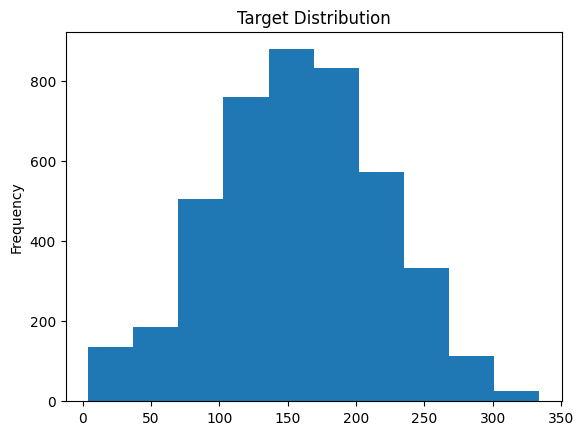

In [9]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [15]:
uid_train = merged_df["uid"].to_list()

In [16]:
uid_test = merged_test["uid"].to_list()

In [20]:
list(set(uid_train) & set(uid_test))

[]

In [11]:
merged_test

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12,year,composite_score
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1",2016,0
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2,2016,0
2,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2,2021,0
3,afnb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.2 or 3 times a week,1.Yes,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1",2016,0
4,afnb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.2 or 3 times a week,1.Yes,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1",2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,zzez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1",2016,0
1101,zzez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1",2021,0
1102,zzft,1. 50–59,"1. 100,000+",1. Married or in civil union,1.0,2. 6 years,1. 1 or 2,0.0,4. Fair,0.0,...,3.2 or 3 times a week,0.No,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2016,0
1103,zzft,1. 50–59,"1. 100,000+",1. Married or in civil union,1.0,2. 6 years,1. 1 or 2,0.0,4. Fair,0.0,...,3.2 or 3 times a week,0.No,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2021,0


In [10]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','year','composite_score'],axis=1)

In [11]:
# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [12]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [13]:
merged_df.shape

(4343, 183)

In [14]:
train_X, val_X, train_y, val_y = train_test_split(merged_df, y,test_size=0.33,random_state=42)

In [40]:
#The model shall handle missing values and encode categorical columns

model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=1000, random_state=42,
     metric='RMSE')

In [41]:
model.fit(train_X, train_y,  eval_set=(val_X, val_y))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1493
[LightGBM] [Info] Number of data points in the train set: 2909, number of used features: 183
[LightGBM] [Info] Start training from score 157.069783


LGBMRegressor(learning_rate=0.01, metric='RMSE', n_estimators=1000,
              random_state=42)

In [ ]:
pred=model.predict(val_X,
                             num_iteration=model.best_iteration_)

In [46]:
score =root_mean_squared_error(val_y, pred)

In [44]:
score

38.47497777705949

In [21]:
#lets generate prediction
fin_pred = model.predict(merged_test)

In [22]:
ss.head()


,uid,year,composite_score
0,abxu,2016,0
1,aeol,2016,0
2,aeol,2021,0
3,afnb,2016,0
4,afnb,2021,0


In [ ]:
ss['composite_score']=fin_pred
#they want ints not floats, so change
ss['composite_score'] = ss['composite_score'].astype(int)
#generate submission
ss.to_csv('../dataset/lgbm_baseline.csv', index=False)